In [1]:
using JuMP, Cbc, Plots

# MS-E2121 - Linear optimization
## Exercise session 4



### Demo exercise: Simplex

\begin{align}
    \max \ & 40x_1 + 60x_2\\
    \text{s.t. } & 2x_1 + x_2 && \le 7 \\
    & x_1 + x_2 && \le 4 \\
    & x_1 + 3x_2 && \le 9 \\
    & x_i \geq 0, \ \forall i \in \{1,2\}
\end{align}

We first plot the problem so we can connect our results with the plot. Based on this, the point (0,3) is not optimal, but we will confirm this using reduced costs.

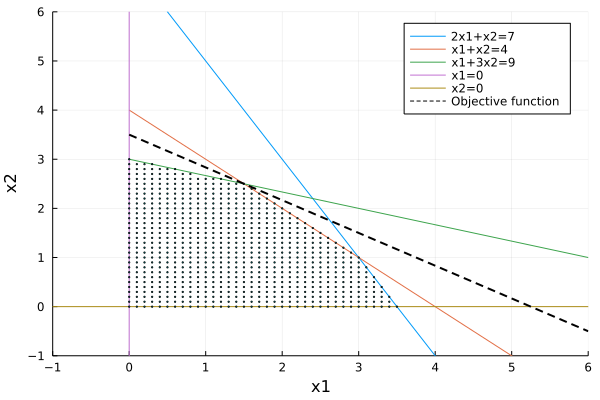

In [2]:
function plot_model(A, b, c; sol=nothing, xlim=5, ylim=5)
    
    # Check problem dimensions and throw an error if not 2D
    m,n = size(A)
    if n != 2
        throw(ArgumentError("Model is not 2-dimensional"))
    end
    
    # Some ranges to help with plotting, these are similar to what you may have used in Matlab
    x1_range = collect(0:0.1:6)
    x2_range = collect(0:0.1:6)
    
    # Create empty plot
    plot(xlim=(-1,6), ylim=(-1,6), xlabel="x1", ylabel="x2")
    
    # Add lines Ax=b to the plot 
    for con in 1:m
        a_x1 = A[con,1]
        a_x2 = A[con,2]
        if a_x1!=0 && a_x2!=0
            plot!(x1_range, (-a_x1*x1_range.+b[con])/a_x2, label="$(a_x1==1 ? "" : a_x1)x1+$(a_x2==1 ? "" : a_x2)x2=$(b[con])")
        elseif a_x1!=0 && a_x2==0
            vline!([b[con]/a_x1], label="$(a_x1==1 ? "" : a_x1)x1=$(b[con])")
        elseif a_x1==0 && a_x2!=0
            hline!([b[con]/a_x2], label="$(a_x2==1 ? "" : a_x2)x2=$(b[con])")
        end
    end
    vline!([0], label="x1=0")
    hline!([0], label="x2=0")

    # Collect the points in the feasible region using a grid
    feasible_region = []
    for x1 in x1_range
        for x2 in x2_range
            if all(A*[x1;x2].<=b)
                push!(feasible_region, [x1, x2])
            end
        end
    end

    # Turn the array of arrays into a 2D-array and plot the points
    feasible_region = hcat(feasible_region...)
    scatter!(feasible_region[1,:], feasible_region[2,:], ms=1, label=false)
    
    # If objective function value was given as an argument, plot the objective function with that value
    if !isnothing(sol)
        plot!(x1_range, (-c[1]*x1_range.+sol)/c[2], linestyle=:dash, linewidth=2, color=:black, label="Objective function")
    end
    
    # This is how you would add a title to your plot
    title!("")
end

A_1 = [2 1; 1 1; 1 3]
b_1 = [7; 4; 9]
c_1 = [-40; -60]
plot_model(A_1,b_1,c_1; sol=-210)

## Standard form

We transform the problem to standard form (minimization with equality constraints) in order to use Simplex method.

\begin{align}
    \min \ & -40x_1 - 60x_2\\
    \text{s.t. } & 2x_1 + x_2 + x_3 && = 7 \\
    & x_1 + x_2 + x_4 && = 4 \\
    & x_1 + 3x_2 + x_5 && = 9 \\
    & x_i \geq 0, \ \forall i \in \{1,...,5\}
\end{align}

In [3]:
# Problem data
A = [2 1 1 0 0; 1 1 0 1 0; 1 3 0 0 1]
b = [7; 4; 9]
c = [-40; -60; 0; 0; 0]


x = [0; 3; 4; 1; 0] # Initial solution
B_ind = [2; 3; 4]   # Indices of basic variables 
B = A[:,B_ind]      # Basis matrix
c_B = c[B_ind]      # Basic variable costs

p = c_B'*inv(B)     # Dual vector for reduced cost calculation 
c_r = c' - p*A      # Reduced costs
println("Reduced costs: $(round.(c_r, digits = 2))")

Reduced costs: [-20.0 0.0 0.0 0.0 20.0]


The reduced cost for $x_1$ is negative => solution is not optimal. A negative reduced cost means that there is a basic direction that leads to a feasible point with a smaller (and thus better) objective value. Let's make $x_1$ a basic variable and calculate the corresponding basic direction $d^1$. The basic components are calculated as $d_B^1 = -B^{-1}A$, the component corresponding to the "entering" variable $x_1$ is 1 and the components corresponding to other non-basic variables are 0. The basic direction thus describes the changes in variables when the entering variable value is increased by 1. 

In [4]:
# Basic direction corresponding to x1
d_B1 = -inv(B)*A[:,1]
d_1 = [1;d_B1;0]
println("Basic direction corresponding to x_1: $(round.(d_1, digits = 2))")

Basic direction corresponding to x_1: [1.0, -0.33, -1.67, -0.67, 0.0]


We can now connect this to the constraints and the figure above. In order to make $x_1$ positive, we move along the constraint $x_1 + 3x_2 \le 9$. For each unit of increase in $x_1$, the other variable $x_2$ must decrease by $\frac{1}{3}$. Next, we need to determine the step length $\theta$, that is, how far along this direction $d_1$ to move. We want to reach the next vertex, but not go further (the points after the first vertex are infeasible). This step will make one basic variable 0 and thus non-basic. That's why we only consider the variables with negative components in the basic direction, the others can't become zero by moving along this direction.

In [5]:
I = findall(d_B1 .< -1E-9) # -1e-9 instead of zero because of possible numerical inaccuracies
θ = minimum(-x[B_ind[I]]./d_B1[I])
println("Ratios: $(round.(-x[B_ind[I]]./d_B1[I], digits = 2))")
println("Minimum ratio θ: $(round(θ, digits = 2))")

Ratios: [9.0, 2.4, 1.5]
Minimum ratio θ: 1.5


Looking at the ratios, we can see that increasing $x_1$ by 9 would make the first basic variable $x_2$ zero. That seems to be true, based on the earlier plot. The other basic variables are slack variables. Making a slack variable zero = making the corresponding constraint active. The second constraint $x_1 + x_2 \le 4$ becomes active when $x_1 = 1.5$, and that is the minimum ratio we obtained.

In [6]:
x_new = x + θ*d_1
println("New point x: $(round.(x_new, digits = 2))")

New point x: [1.5, 2.5, 1.5, 0.0, 0.0]


Now that we have a new basic feasible solution, we can check whether it is optimal or not by calculating the reduced costs

In [7]:
B_ind_new = [2; 3; 1]
B_new = A[:,B_ind_new]
c_B_new = c[B_ind_new]

p_new = c_B_new'*inv(B_new)
c_r_new = c' - p_new*A
println("Reduced costs: $(round.(c_r_new, digits = 2))")

Reduced costs: [0.0 0.0 0.0 30.0 10.0]


All nonnegative, the point $x_{new}$ is optimal

### Student exercise:
Solve the following problem using two-phase simplex

\begin{align*}
    \max \ & 5x_1 + &&x_2 \\
    \text{s.t. } & 2x_1 + &&x_2 &&& \ge 5 \\
    & &&x_2 &&& \ge 1 \\
    & 2x_1 + &&3x_2 &&& \le 12 \\
\end{align*}
\begin{align*}
x_1, x_2 \ge 0, \ \forall i \in \{1,2\}
\end{align*}

In standard form:

\begin{align}
    \min \ & -5x_1 - x_2\\
    \text{s.t. } & 2x_1 + x_2 - x_3 && = 5 \\
    & x_2 - x_4 && = 1 \\
    & 2x_1 + 3x_2 + x_5 && = 12 \\
    & x_i \geq 0, \ \forall i \in \{1,...,5\}
\end{align}

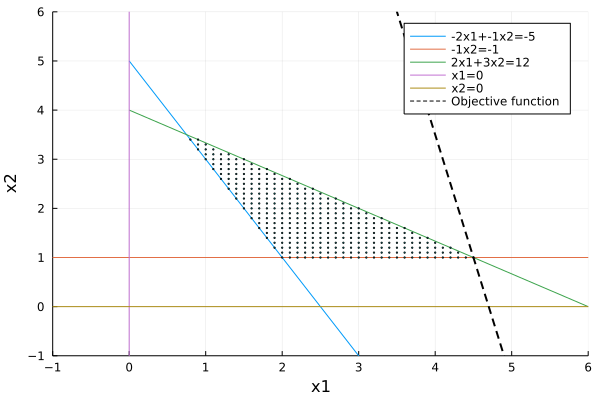

In [8]:

function plot_model(A, b, c; sol=nothing, xlim=5, ylim=5)
    
    # Check problem dimensions and throw an error if not 2D
    m,n = size(A)
    if n != 2
        throw(ArgumentError("Model is not 2-dimensional"))
    end
    
    # Some ranges to help with plotting, these are similar to what you may have used in Matlab
    x1_range = collect(0:0.1:6)
    x2_range = collect(0:0.1:6)
    
    # Create empty plot
    plot(xlim=(-1,6), ylim=(-1,6), xlabel="x1", ylabel="x2")
    
    # Add lines Ax=b to the plot 
    for con in 1:m
        a_x1 = A[con,1]
        a_x2 = A[con,2]
        if a_x1!=0 && a_x2!=0
            plot!(x1_range, (-a_x1*x1_range.+b[con])/a_x2, label="$(a_x1==1 ? "" : a_x1)x1+$(a_x2==1 ? "" : a_x2)x2=$(b[con])")
        elseif a_x1!=0 && a_x2==0
            vline!([b[con]/a_x1], label="$(a_x1==1 ? "" : a_x1)x1=$(b[con])")
        elseif a_x1==0 && a_x2!=0
            hline!([b[con]/a_x2], label="$(a_x2==1 ? "" : a_x2)x2=$(b[con])")
        end
    end
    vline!([0], label="x1=0")
    hline!([0], label="x2=0")

    # Collect the points in the feasible region using a grid
    feasible_region = []
    for x1 in x1_range
        for x2 in x2_range
            if all(A*[x1;x2].<=b)
                push!(feasible_region, [x1, x2])
            end
        end
    end

    # Turn the array of arrays into a 2D-array and plot the points
    feasible_region = hcat(feasible_region...)
    scatter!(feasible_region[1,:], feasible_region[2,:], ms=1, label=false)
    
    # If objective function value was given as an argument, plot the objective function with that value
    if !isnothing(sol)
        plot!(x1_range, (-c[1]*x1_range.+sol)/c[2], linestyle=:dash, linewidth=2, color=:black, label="Objective function")
    end
    
    # This is how you would add a title to your plot
    title!("")
end

A = [-2 -1; 0 -1; 2 3]
b = [-5; -1; 12]
c = [-5; -1]
plot_model(A,b,c; sol=-23.5)

### Phase 1
The goal is to obtain a feasible starting point for the second phase.

\begin{align}
    \min \ & x_6 + x_7\\
    \text{s.t. } & 2x_1 + x_2 - x_3 + x_6 && = 5 \\
    & x_2 - x_4 + x_7 && = 1 \\
    & 2x_1 + 3x_2 + x_5 && = 12 \\
    & x_i \geq 0, \ \forall i \in \{1,...,5\}
\end{align}

In [18]:
#%
# Problem data
A = [2 1 -1 0 0 1 0; 0 1 0 -1 0 0 1; 2 3 0 0 1 0 0]
b = [5; 1; 12]
c = [0; 0; 0; 0; 0; 1; 1]


x = [0; 0; 0; 0; 12; 5; 1] # Initial solution

B_ind = [5; 6; 7]   # Indices of basic variables 
B = A[:,B_ind]      # Basis matrix
c_B = c[B_ind]      # Basic variable costs

p = c_B'*inv(B)     # Dual vector for reduced cost calculation 
c_r = c' - p*A      # Reduced costs
println("Reduced costs: $c_r")
#%

Reduced costs: [-2.0 -2.0 1.0 1.0 0.0 0.0 0.0]


In [19]:
#%
# Choose x2 as the entering variable because it has the most negative reduced cost
# Calculate basic direction corresponding to x2
i = 2
d_B = -inv(B)*A[:,i]
d = zeros(7)
d[B_ind] = d_B
d[i] = 1

# Calculate the minimum ratio and move to a new vertex
I = findall(d_B .< -1E-9) # -1e-9 instead of zero because of possible numerical inaccuracies
θ = minimum(-x[B_ind[I]]./d_B[I])

x = x + θ*d
println("New point x: $x")
#%

New point x: [0.0, 1.0, 0.0, 0.0, 9.0, 4.0, 0.0]


In [20]:
#%
# Calculate reduced costs to see if the point/basis is optimal
B_ind = [5; 6; 2]   # Indices of basic variables 
B = A[:,B_ind]      # Basis matrix
c_B = c[B_ind]      # Basic variable costs

p = c_B'*inv(B)     # Dual vector for reduced cost calculation 
c_r = c' - p*A      # Reduced costs
println("Reduced costs: $c_r")
#%

Reduced costs: [-2.0 0.0 1.0 -1.0 0.0 0.0 2.0]


In [21]:
#%
# Repeat the steps above until reduced costs nonnegative
# Basic direction corresponding to x1
i = 1
d_B = -inv(B)*A[:,i]
d = zeros(7)
d[B_ind] = d_B
d[i] = 1

I = findall(d_B .< -1E-9) # -1e-9 instead of zero because of possible numerical inaccuracies
θ = minimum(-x[B_ind[I]]./d_B[I])

x = x + θ*d
println("New point x: $x")
#%

New point x: [2.0, 1.0, 0.0, 0.0, 5.0, 0.0, 0.0]


In [22]:
#%
B_ind = [5; 1; 2]   # Indices of basic variables 
B = A[:,B_ind]      # Basis matrix
c_B = c[B_ind]      # Basic variable costs

p = c_B'*inv(B)     # Dual vector for reduced cost calculation 
c_r = c' - p*A      # Reduced costs
println("Reduced costs: $c_r")
#%

Reduced costs: [0.0 0.0 0.0 0.0 0.0 1.0 1.0]


### Phase 2
Starting from the feasible solution obtained from phase 1, find the optimal solution to the original problem.

In [23]:
#%
# All reduced costs are nonnegative and the basis does not contain artificial variables, phase 1 was thus successful
# In order to continue to phase 2, we need to return to the original problem, starting from the basis we obtained from phase 1.
A = A[:,1:5]
x = x[1:5]
c = [-5; -1; 0; 0; 0]

c_B = c[B_ind]      # Basic variable costs
p = c_B'*inv(B)     # Dual vector for reduced cost calculation 
c_r = c' - p*A      # Reduced costs
println("Reduced costs: $c_r")
#%

Reduced costs: [0.0 0.0 -2.5 1.5 0.0]


In [24]:
#%
# Basic direction corresponding to x3
i = 3
d_B = -inv(B)*A[:,i]
d = zeros(5)
d[B_ind] = d_B
d[i] = 1

I = findall(d_B .< -1E-9) # -1e-9 instead of zero because of possible numerical inaccuracies
θ = minimum(-x[B_ind[I]]./d_B[I])

x = x + θ*d
println("New point x: $x")
#%

New point x: [4.5, 1.0, 5.0, 0.0, 0.0]


In [25]:
#%
B_ind = [1; 2; 3]   # Indices of basic variables 
B = A[:,B_ind]      # Basis matrix
c_B = c[B_ind]      # Basic variable costs

p = c_B'*inv(B)     # Dual vector for reduced cost calculation 
c_r = c' - p*A      # Reduced costs
println("Reduced costs: $c_r")
#%

Reduced costs: [0.0 0.0 0.0 6.5 2.5]


In [26]:
#%
println("Optimal solution $(sum(-c.*x)) at x=$(x[1:2])")
#%

Optimal solution 23.5 at x=[4.5, 1.0]
